In [5]:
!pip install opendatasets

In [6]:
import opendatasets as od

In [7]:
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: deshnandini
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:21<00:00, 113MB/s]


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,GlobalAvgPool2D,BatchNormalization,MaxPooling2D,Dropout,Flatten,AvgPool2D,GlobalAveragePooling2D
from keras import optimizers


In [9]:
import tensorflow as tf

# {normal:0,pneumonia:1}
# we have used grayscale for binary

def dataloading(img_size=(124, 124),batch_size = 32):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train = datagen.flow_from_directory(
        r'/content/chest-xray-pneumonia/chest_xray/train',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode = 'grayscale'
    )

    test = datagen.flow_from_directory(
        r'/content/chest-xray-pneumonia/chest_xray/test',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode = 'grayscale'
    )

    val = datagen.flow_from_directory(
        r'/content/chest-xray-pneumonia/chest_xray/val',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        color_mode = 'grayscale'

    )

    return train, test, val


In [10]:
train_images,test_images,val_images = dataloading()
# 32*x = 5216 batch size of 32
print(5215//32)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
162


In [11]:
import tensorflow as tf

def build_model(hp):
    input_shape = (124,124,1)

    model = Sequential([
        Conv2D(
        filters = hp.Int('filter_1',min_value = 32,max_value = 64,step = 16),
        kernel_size = hp.Choice('kernel_1',values = [3,5,7]),
        input_shape = input_shape,
        activation = 'relu',
        ),
        tf.keras.layers.AveragePooling2D(
        pool_size=(hp.Choice('pool_height_1', values=[2, 3]), hp.Choice('pool_width_1', values=[2, 3])),
        strides=(hp.Choice('stride_height_1', values=[1, 2]), hp.Choice('stride_width_1', values=[1, 2])),
        padding='valid',
        ),
        Conv2D(
          filters = hp.Int('filter_2',min_value = 32,max_value = 64,step = 16),
        kernel_size = hp.Choice('kernel_2',values = [3,5]),
        activation = 'relu',
        ),
        tf.keras.layers.AveragePooling2D(
        pool_size=(hp.Choice('pool_height_2', values=[2, 3]), hp.Choice('pool_width_2', values=[2, 3])),
            strides=(hp.Choice('stride_height_2', values=[1, 2]), hp.Choice('stride_width_2', values=[1, 2])),
        padding='valid',
        ),
        Conv2D(
            filters = hp.Int('filter_3',min_value = 32,max_value = 64,step = 16),
        kernel_size = hp.Choice('kernel_3',values = [3,5]),
        activation = 'relu',
        ),
        Flatten(),
        Dense(units=hp.Int('units_0',min_value=16,max_value = 64,step = 16),activation = 'relu'),
        Dense(units=hp.Int('units_0',min_value=16,max_value = 64,step = 16),activation = 'relu'),
        Dropout(0.5),
        Dense(1,activation='sigmoid'),
    ])
    model.compile(optimizer = optimizers.Adam(hp.Choice('learning_rate',values = [1e-4, 1e-3, 1e-2,1e-1])),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

    return model


In [13]:
!pip install keras_tuner
import keras_tuner as kt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [14]:
from kerastuner.tuners import BayesianOptimization

tuner = BayesianOptimization(
    build_model,
    objective = 'val_accuracy',
    max_trials = 1,
    executions_per_trial = 1,
    directory='bayesian_opt',
    project_name='chest_xray_model'
)

<ipython-input-14-5b8cc32ed838>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
tuner.search(train_images,epochs = 3,validation_data = test_images)

Trial 1 Complete [00h 17m 25s]
val_accuracy: 0.7836538553237915

Best val_accuracy So Far: 0.7836538553237915
Total elapsed time: 00h 17m 25s


In [16]:
model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display best model summary and hyperparameters
model.summary()
print("Best hyperparameters:", best_hyperparameters.values)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 122, 122, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 120, 121, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 118, 119, 48)        │          13,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 59, 59, 48)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 57, 57, 32)          │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 103968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,654,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,686,289 (25.51 MB)

 Trainable params: 6,686,289 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters: {'filter_1': 32, 'kernel_1': 3, 'pool_height_1': 3, 'pool_width_1': 2, 'stride_height_1': 1, 'stride_width_1': 1, 'filter_2': 48, 'kernel_2': 3, 'pool_height_2': 2, 'pool_width_2': 2, 'stride_height_2': 2, 'stride_width_2': 2, 'filter_3': 32, 'kernel_3': 3, 'units_0': 64, 'learning_rate': 0.001}


In [17]:

model.fit(train_images,epochs=10,validation_data=val_images,validation_split=0.2)



Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9516 - loss: 0.1311 - val_accuracy: 0.7500 - val_loss: 0.6006
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9644 - loss: 0.0939 - val_accuracy: 0.7500 - val_loss: 0.4656
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9753 - loss: 0.0700 - val_accuracy: 0.8125 - val_loss: 0.3959
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9767 - loss: 0.0676 - val_accuracy: 0.8750 - val_loss: 0.2182
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9805 - loss: 0.0559 - val_accuracy: 0.8125 - val_loss: 0.3022
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9873 - loss: 0.0427 - val_accuracy: 0.9375 - val_loss: 0.1003
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.9902 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 0.0607
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9867 - loss: 0.0321 - val_accu

In [18]:
import keras
keras.saving.save_model(model,"hush.keras")

[]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
F1 Score: 0.88888889


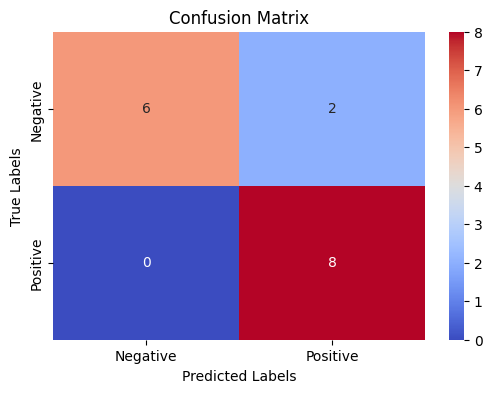

Accuracy: 0.87500000


In [19]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

model = load_model(r"/content/hush.keras")

# ok so this model has val_images and it has both labels and images so we need to segragate it
val_data, val_labels = [], []
for i in range(len(val_images)):
    data, labels = val_images[i]
    print(val_data)
    val_data.extend(data)
    val_labels.extend(labels)


val_data = np.array(val_data)
val_labels = np.array(val_labels)

predictions = model.predict(val_data, batch_size=32)
pred_labels = (predictions > 0.5).astype(int).flatten()


f1 = f1_score(val_labels, pred_labels)
print(f"F1 Score: {f1:.8f}")

cm= confusion_matrix(val_labels,pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



accuracy = accuracy_score(val_labels, pred_labels)
print(f"Accuracy: {accuracy:.8f}")
